# SNR test analysis continued (towards paper-01): 

**Making the analysis shareable and presentable**

Date: 03/29/2023

**Notes**: 

* Hoping this can serve as an basis for how the future ratio analysis can be done.  

## **Imports**

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import uproot4
from lmfit import minimize, Parameters, fit_report
import lmfit
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Jupyter Lab imports.
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

# Path to local imports.
sys.path.append("/home/drew/He6CRES/rocks_analysis_pipeline/")
from results import ExperimentResults
from rocks_utility import he6cres_db_query

# Path to local imports.
sys.path.append("/home/drew/He6CRES/he6-cres-spec-sims/")

# Local imports.
import he6_cres_spec_sims.spec_tools.spec_calc.spec_calc as sc
import he6_cres_spec_sims.experiment as exp
import he6_cres_spec_sims.spec_tools.beta_source.beta_spectrum as bs

# Local imports for plotting ratios and such. 
import analysis_functions.ratio_experiment as re
import analysis_functions.ratio_prediction as rp
import analysis_functions.quality_control_methods as qc
import analysis_functions.plotting_methods as pm
import analysis_functions.event_clustering as clust


import mc_functions.wall_effect as we
import mc_functions.energy_domain as ed
import mc_functions.from_below as fb

## To Do's: 

*  

## Notes: 

* 

## **Step 0: Grab the results from rocks**

### Load Ne19 data

* Not grabbing root files for now. Will do this as a diagnostic if necessary. 

In [3]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
include_root_files = False
max_root_files_to_grab = 3
rebuild_experiment_dir = False

snrs = [9]
aids = [26]
n_files = 100
experiment_names = [f"ne_snr{snr}_fn{n_files}" for snr in snrs]
print(experiment_names)

ne_snr_results = [ ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = aid, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )
                  for (experiment_name, aid) in zip(experiment_names, aids)]


['ne_snr9_fn100']
Keeping existing experiment directory.




### Load He6 data

* Not grabbing root files for now. Will do this as a diagnostic if necessary. 

In [4]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
include_root_files = False
max_root_files_to_grab = 3
rebuild_experiment_dir = False


snrs = [9]
aids = [22]
n_files = 100
experiment_names = [f"he_snr{snr}_fn{n_files}" for snr in snrs]
print(experiment_names)

he_snr_results = [ ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = aid, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )
                  for (experiment_name, aid) in zip(experiment_names, aids)]


['he_snr9_fn100']
Keeping existing experiment directory.




### Build all he and ne results into one dictionary

In [5]:
# Aggregate the results.
snr_cuts = np.array([9])
snr_study = { "ne": dict(zip(snr_cuts,ne_snr_results)),
              "he": dict(zip(snr_cuts,he_snr_results))}

## **Step 1: Another Layer of DBSCAN Clustering.** 

* I need to first apply the cuts that I found were most appropriate. 

### Define the clust_params. Based on testing each field separately. 

* I need to think of a more quantitative way to do this.

#### Epsilon Ideas: 

**Idea**: How to decide this epsilon without reference to the ratio?

1. What if we scale the epsilon with the slope?
    * This didn't work well. Either at low or high fields depending. 

In [6]:
set_fields = np.arange(.75,3.5,.25)

# Freq_BW
freq_BW = np.array([18e9 ,  19.1e9])

# Build baseline ratio
freq_BWs_bl = np.tile(freq_BW, (len(set_fields), 1))

powers = sc.power_larmor(set_fields, freq_BW.mean())
energys = sc.freq_to_energy(freq_BW.mean(), set_fields)
slopes = sc.df_dt(energys, set_fields, powers)

print(list(zip(slopes/1e11, set_fields)))

[(0.005020343995841086, 0.75), (0.030433873924843726, 1.0), (0.07619604550846547, 1.25), (0.14739401916036102, 1.5), (0.24911495529418545, 1.75), (0.38644601432359266, 2.0), (0.5644743566622387, 2.25), (0.7882871427237774, 2.5), (1.0629715329218639, 2.75), (1.3936146876701523, 3.0), (1.7853037673822982, 3.25)]


In [7]:
# features = [ "EventTimeIntc", "EventStartTime"]
# set_fields = np.arange(.75,3.5,.25)

epss = np.zeros_like(set_fields)

epss = .03*(5.64474357e+10)**2/slopes**2
epss = np.array([.5,.02,.02,.01,.001,.001, .0005, .0001, .00001, .00001, .00001]) # Verified this is good. 
# epss = np.array([.5,.2,.1,.04,.03,.03, .005, .001, .001, .001, .001]) # Trying other options...
# epss = np.array([.5,.2,.08,.02,.01,.01, .002, .001, .001, .001, .001])# Verified this is better. (before 3/21/23)


clust_params = {}

for (set_field, eps, slope) in zip(set_fields, epss, slopes): 
    
    clust_params.update({set_field : {"eps":eps}})
    clust_params[set_field].update(  {"slope": slope} )
    clust_params[set_field].update( {"features":["EventTimeIntc"]} )
    # clust_params.update({set_field : {"slope": slope}})
#     if set_field < 2.5: 
#         clust_params[set_field].update(  {"features":features} )
#     else: 
#         clust_params[set_field].update( {"features":["EventTimeIntc"]} )
        
print(clust_params)

{0.75: {'eps': 0.5, 'slope': 502034399.5841086, 'features': ['EventTimeIntc']}, 1.0: {'eps': 0.02, 'slope': 3043387392.4843726, 'features': ['EventTimeIntc']}, 1.25: {'eps': 0.02, 'slope': 7619604550.846546, 'features': ['EventTimeIntc']}, 1.5: {'eps': 0.01, 'slope': 14739401916.0361, 'features': ['EventTimeIntc']}, 1.75: {'eps': 0.001, 'slope': 24911495529.418545, 'features': ['EventTimeIntc']}, 2.0: {'eps': 0.001, 'slope': 38644601432.35927, 'features': ['EventTimeIntc']}, 2.25: {'eps': 0.0005, 'slope': 56447435666.22386, 'features': ['EventTimeIntc']}, 2.5: {'eps': 0.0001, 'slope': 78828714272.37775, 'features': ['EventTimeIntc']}, 2.75: {'eps': 1e-05, 'slope': 106297153292.18639, 'features': ['EventTimeIntc']}, 3.0: {'eps': 1e-05, 'slope': 139361468767.01523, 'features': ['EventTimeIntc']}, 3.25: {'eps': 1e-05, 'slope': 178530376738.22983, 'features': ['EventTimeIntc']}}


In [9]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf)
            } # This was verified to work 


### Drop bad rids, make intial cuts, then cluster. 

* Question: 
    * Why does this effect higher fields for ne more than he? 

In [11]:
drop_rid_list = [548, 549, 522, 495, 377]
cluster = True

for isotope in snr_study.keys(): 
    for cut in snr_cuts: 
        
        # Drop bad rids.
        snr_study[isotope][cut].events = snr_study[isotope][cut].events[~snr_study[isotope][cut].events.run_id.isin(drop_rid_list)]
        snr_study[isotope][cut].tracks = snr_study[isotope][cut].tracks[~snr_study[isotope][cut].tracks.run_id.isin(drop_rid_list)]
        snr_study[isotope][cut].root_files = snr_study[isotope][cut].root_files[~snr_study[isotope][cut].root_files.run_id.isin(drop_rid_list)]
        
        # Make initial cuts. Need to do this before clustering or we cluster good events into bad.   
        events = snr_study[isotope][cut].events
        print(f"{isotope}, {cut}.\npre cuts events: {len(events)}")

        # snr_study[isotope][cut].events = re.cut_df(events, both_cuts)
        events_cut = re.cut_df(events, both_cuts)
        snr_study[isotope][cut].events = events_cut
        print(f"\npost cuts events: {len(events_cut)}")
        # Cluster
        if cluster: 
            print(f"pre cluster events: {len(events_cut)} ")
            snr_study[isotope][cut].events = clust.cluster_and_clean_events(events_cut, 
                                                                            clust_params=clust_params,
                                                                            diagnostics=True)
            print(f"post clust events: {len(snr_study[isotope][cut].events)}")

ne, 9.
pre cuts events: 25852

post cuts events: 25713
pre cluster events: 25713 
Summary of clustring: 


Fractional reduction in counts from clustering: set_field
0.75    0.636364
1.00    0.794140
1.25    0.800294
1.50    0.886256
1.75    0.995943
2.00    0.997340
2.25    1.000000
2.50    1.000000
2.75    1.000000
3.00    0.995816
3.25    0.974468
Name: file_id, dtype: float64

Pre-clustering means:


,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,...,mTotalSNR,sTotalSNR,mMaxSNR,sMaxSNR,mTotalNUP,sTotalNUP,mTotalPower,sTotalPower,field,monitor_rate
set_field,,,,,,,,,,,,,,,,,,,,,
0.75,558.306818,44.352273,1.784091,0.414049,0.416054,5.241321e+08,5.259577e+08,0.002004,1.825561e+06,0.721437,...,55.478089,7.210083,14.280211,2.108258,49.248468,6.719154,126.719603,16.736911,0.750159,11539.572045
1.00,552.833959,47.782870,2.873028,0.502570,0.507645,6.141300e+08,6.336925e+08,0.005075,1.956245e+07,0.716881,...,58.467360,7.997692,15.378098,2.843289,51.742223,7.470390,124.427065,18.978505,1.000200,11604.615860
1.25,544.019579,50.542340,3.206559,0.499937,0.508976,5.972175e+08,6.733806e+08,0.009039,7.616311e+07,0.731900,...,60.798996,8.900808,16.116617,3.223128,53.947360,8.374535,128.501388,23.871100,1.250300,11182.785751
1.50,538.006319,49.425750,3.641390,0.502126,0.512325,5.464735e+08,7.047941e+08,0.010200,1.583206e+08,0.736953,...,62.188725,9.561855,16.626040,3.513631,55.298315,9.048719,132.611645,27.540779,1.500324,9800.468069
1.75,531.979136,49.521298,4.549986,0.496149,0.506502,4.983548e+08,7.629970e+08,0.010353,2.646422e+08,0.743943,...,63.927953,10.319594,17.296673,3.858415,56.963390,9.812044,136.232294,30.762456,1.750366,10240.415120
2.00,526.033857,49.822491,5.222249,0.492648,0.502383,4.313173e+08,8.124946e+08,0.009735,3.811773e+08,0.750888,...,64.761313,11.300417,17.569384,4.089194,57.787138,10.781671,138.745482,34.514746,2.000402,10554.954883
2.25,519.480146,49.347508,5.496198,0.491330,0.499206,4.185042e+08,8.668246e+08,0.007876,4.483205e+08,0.760962,...,64.631200,10.668847,17.572096,4.054706,57.606336,10.189993,136.525710,34.451055,2.250432,10781.740324
2.50,514.027436,48.865641,4.897949,0.488775,0.495346,3.892128e+08,9.095324e+08,0.006570,5.203196e+08,0.763833,...,62.155952,10.167032,16.699191,3.698792,55.222614,9.664552,130.166344,34.158581,2.500450,10481.307210
2.75,508.006970,50.129771,4.053435,0.497963,0.503331,3.888937e+08,9.602374e+08,0.005368,5.713436e+08,0.780420,...,59.221871,9.122332,15.675859,3.238704,52.344364,8.621611,121.057687,32.344658,2.750550,11040.671752



Pre-clustering stds:


,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,...,mTotalSNR,sTotalSNR,mMaxSNR,sMaxSNR,mTotalNUP,sTotalNUP,mTotalPower,sTotalPower,field,monitor_rate
set_field,,,,,,,,,,,,,,,,,,,,,
0.75,1.244371,29.092417,1.235945,0.275048,0.274814,1.821099e+08,1.820479e+08,0.001179,1.348923e+06,0.142552,...,3.950531,4.001807,1.279182,0.997504,3.769846,3.600781,29.084741,10.818955,0.000007,480.024768
1.00,1.402014,28.498757,2.066114,0.287347,0.287140,3.090876e+08,3.081265e+08,0.005052,1.907224e+07,0.110772,...,7.027006,2.952950,2.134316,1.105384,6.811033,2.715326,40.017683,8.642396,0.000005,289.072298
1.25,1.386449,28.660985,2.013037,0.292316,0.292323,3.297001e+08,3.222746e+08,0.008611,7.198472e+07,0.099461,...,8.137705,3.092460,2.601159,1.221303,7.922331,2.940644,40.387209,9.598057,0.000003,534.127651
1.50,1.410002,29.064466,2.273860,0.295390,0.295424,3.390306e+08,3.309725e+08,0.008888,1.370433e+08,0.100413,...,8.590428,3.189285,2.786732,1.328195,8.365189,3.085537,40.691737,9.841181,0.000007,314.818706
1.75,1.409748,28.793705,2.852618,0.293015,0.293054,3.439725e+08,3.376253e+08,0.008470,2.152700e+08,0.113014,...,9.074271,3.442328,3.025638,1.469373,8.825095,3.353133,40.914860,10.984674,0.000003,242.673069
2.00,1.409009,28.777089,3.220142,0.290203,0.290120,3.359705e+08,3.414922e+08,0.007183,2.798964e+08,0.110049,...,8.946962,3.943887,2.905495,1.474849,8.641494,3.871058,38.260838,12.300689,0.000006,271.069772
2.25,1.132161,28.791857,3.324586,0.291017,0.291041,3.355022e+08,3.271356e+08,0.005633,3.193115e+08,0.102481,...,8.213207,3.362998,2.784246,1.408466,7.948207,3.282777,35.747691,11.804376,0.000009,242.083593
2.50,1.402199,28.549178,2.950536,0.288623,0.288748,3.240363e+08,3.073220e+08,0.004262,3.362939e+08,0.103395,...,6.896535,2.939171,2.236693,1.209893,6.638198,2.849860,30.840218,11.330627,0.000005,244.749811
2.75,1.402527,28.603046,2.497568,0.290798,0.290840,3.105207e+08,2.679312e+08,0.003126,3.318022e+08,0.109978,...,5.645444,2.544373,1.769650,1.031497,5.392322,2.403806,25.940648,10.351298,0.000006,488.858172



Post-clustering means:


NameError: name 'post_cuts_summary_mean' is not defined

## Ideas: 

* Say you fit to the max prob of being observed at each cut and see if they are consistent? This could be interesting, note I could do this without 

## **Step 3: Build and plot the ratio**

* Follow along from the building spectrum ipynb. 

**Notes**: 

* Basing much of this analysis off of this: http://localhost:8889/lab/tree/He6CRES/rocks_analysis_notebooks/building_spectrum_11282022.ipynb but not here. 

In [14]:

both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.001e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }
ne_cuts = both_cuts
he_cuts = both_cuts

### Plot Ratio and normed rate vs freq start cut

* Note: HUGE. This somehow gave sensible results. freq_BW = np.array([17.9e9 + spectrum_cuts["EventStartFreq"][0] ,  19.1e9 -  spectrum_cuts["EventStartFreq"][1]]), even though it's clearly wrong. Shit. 

In [15]:
set_fields = np.arange(1.5,3.5,.25)
freq_BW = np.array([18.0e9,19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

[1.7999e+10 1.9100e+10]
reduced chisq: 245.68048192470778


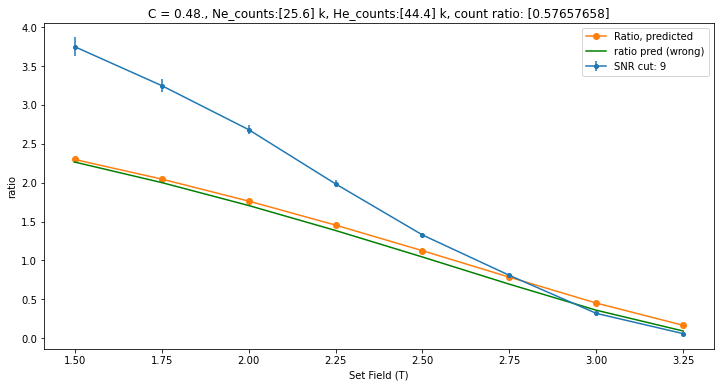

[  99. 1200.]
[1.8099e+10 1.9100e+10]
reduced chisq: 45.367041611591546


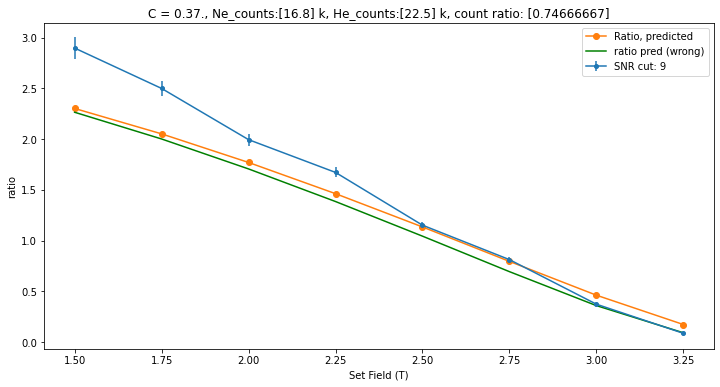

[ 199. 1200.]
[1.8199e+10 1.9100e+10]
reduced chisq: 20.020229443065766


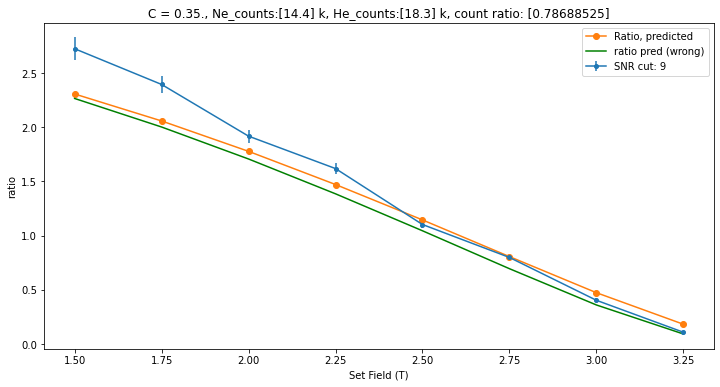

[ 299. 1200.]
[1.8299e+10 1.9100e+10]
reduced chisq: 16.48138064755389


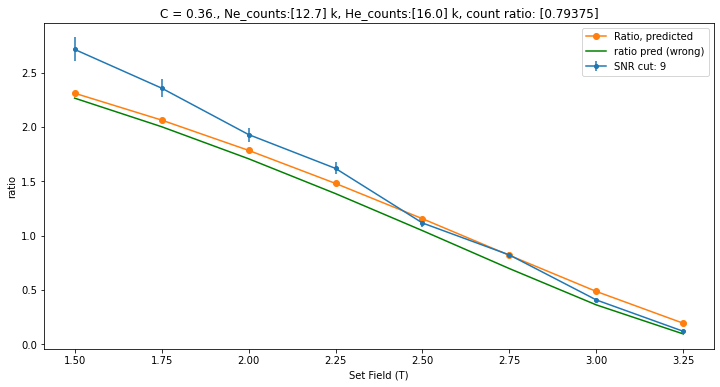

[ 399. 1200.]
[1.8399e+10 1.9100e+10]
reduced chisq: 10.015429305890418


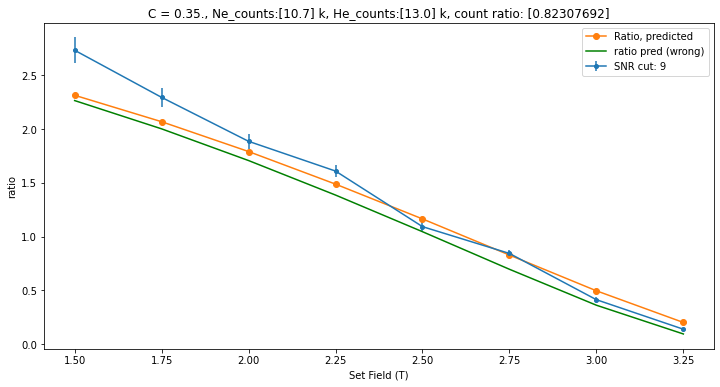

[ 499. 1200.]
[1.8499e+10 1.9100e+10]
reduced chisq: 6.4939014428447654


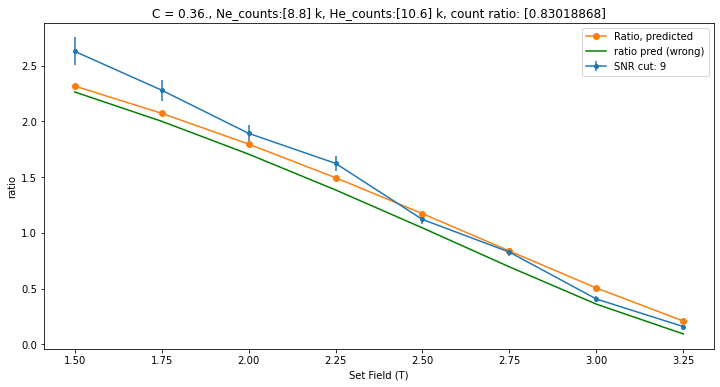

[ 599. 1200.]
[1.8599e+10 1.9100e+10]
reduced chisq: 5.821068927253109


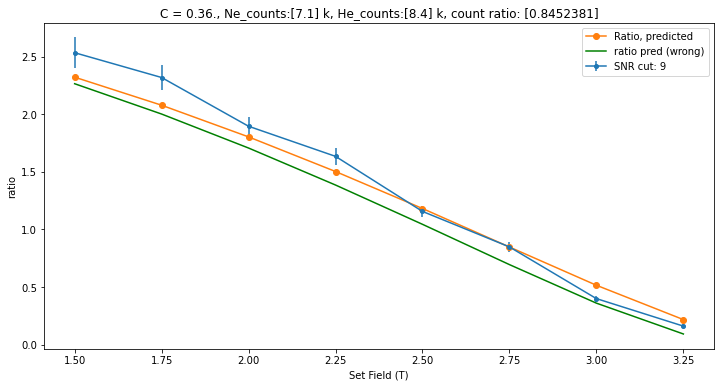

[ 699. 1200.]
[1.8699e+10 1.9100e+10]
reduced chisq: 4.594328696382669


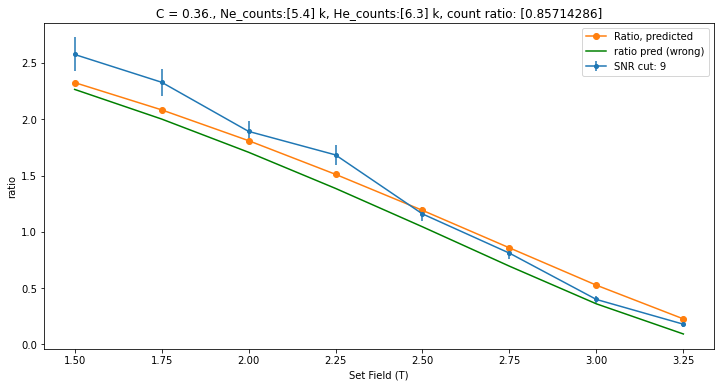

[ 799. 1200.]
[1.8799e+10 1.9100e+10]
reduced chisq: 3.836071782867091


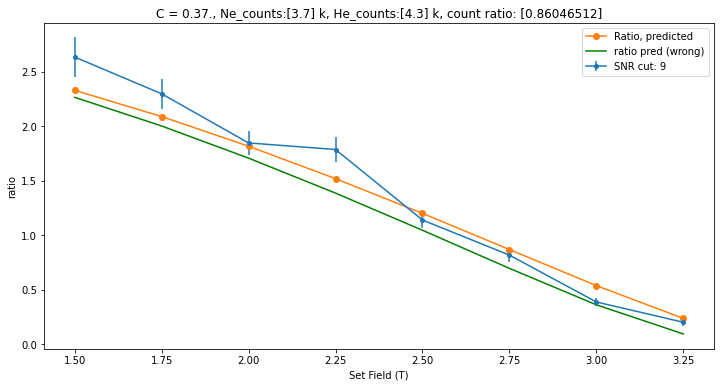

[ 899. 1200.]
[1.8899e+10 1.9100e+10]
reduced chisq: 2.5306558097690868


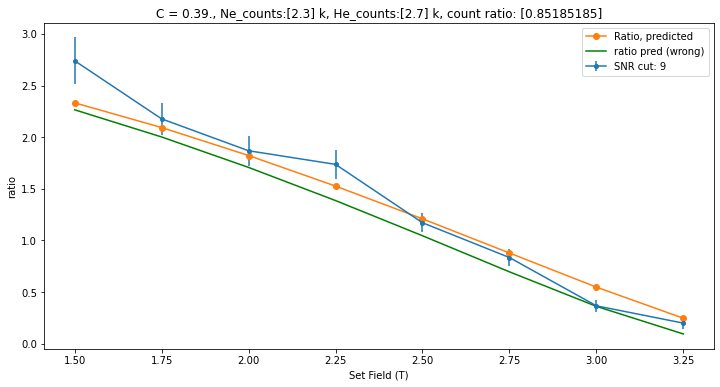

[ 999. 1200.]


In [16]:
%matplotlib inline

# set_fields = np.arange(1.25,3.5,.25)

# for (freq1, freq2) in zip(np.arange(100,1100, 100),np.arange(300,1300, 100)): 
for freq1 in np.arange(99,1000,100):     
    spectrum_cuts = {
                "EventStartFreq": ((freq1)*1e6, (1200)*1e6)
                }

    ne_cuts = {**both_cuts, **spectrum_cuts}
    he_cuts = {**both_cuts, **spectrum_cuts}

    ne_spectra = []
    he_spectra = []       
    
    for cut in snr_cuts:

        ne = snr_study["ne"][cut]
        ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts))

        he = snr_study["he"][cut]
        he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts))

    snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                          "he": dict(zip(snr_cuts,he_spectra))}
    # fig, ax = plt.subplots(figsize=(12,6))
    # fig1, ax1 = plt.subplots(figsize=(12,6))
    # fig2, ax2 = plt.subplots(figsize=(12,6))
    # for cut in snr_cuts:
    #     for isotope in snr_study_spectra.keys():
    #         # print(snr_study_spectra[isotope][cut].columns)
    #         snr_study_spectra[isotope][cut].plot(x = "set_field", y = "tot_monitor_rate", ax = ax1, label = f"{cut}_{isotope}")
    #         snr_study_spectra[isotope][cut].plot(x = "set_field", y = "seconds_of_data", ax = ax2, label = f"{cut}_{isotope}")
    #         snr_study_spectra[isotope][cut].plot(x = "set_field", y = "mon_adjusted_count", ax = ax, label = f"{cut}_{isotope}")
    # plt.show()
    # Make the experimental ratio with new normalization scheme. 
    
    fig0, ax0 = plt.subplots(figsize=(12,6))
    
    ne_counts = []
    he_counts = []
    for cut in snr_cuts: 
        
        ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])
        # print(ratio_exp)
        # Make the predicted ratio.
        freq_BW = np.array([17.9e9 + spectrum_cuts["EventStartFreq"][0] ,  17.9e9 +  spectrum_cuts["EventStartFreq"][1]])
        print(freq_BW)
        freq_BW_wrong = np.array([17.9e9 ,  18.3e9])
        freq_BWs_wrong = np.tile(freq_BW_wrong, (len(set_fields), 1))
        
        # freq_BW = np.array([18.3e9,19.1e9])
        freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

        
        # # freq_BWs = np.tile(freq_BW, (len(set_fields), 1))
        # offset = np.linspace(0, 200e6, len(set_fields))
        # freq_BWs_wrong = freq_BWs - offset[:,None]
        # print(freq_BWs_wrong)
        ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)
        
        # Exploring how different the wrong one is. 
        # freq_BWs_wrong = np.tile(freq_BW_wrong, (len(set_fields), 1))
        
        ratio_pred_wrong = rp.AUC_expectation(set_fields, freq_BWs_wrong, b = 0, plot = False)
        
        
        # Only take the fields you want: 
        ratio_pred = ratio_pred[ratio_pred.index.isin(set_fields)]
        ratio_pred_wrong= ratio_pred_wrong[ratio_pred_wrong.index.isin(set_fields)]
        ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

        # Fit to the free normalization parameter. 
        def objfunc_chisq(C, ratio_pred, ratio_exp ): 

            # I think the lmfit does the least squares on these values for you but double check. 
            chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])
            return chisq_gauss

        my_pars = Parameters()
        my_pars.add('C', value=1, min=0, max = 10, vary =True)

        result = minimize(objfunc_chisq, my_pars, args = (ratio_pred, ratio_exp))
        print(f"reduced chisq: {result.redchi}")
        C = result.params["C"].value
        ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
        ratio_exp["sRatio"] = C*ratio_exp["sRatio"]
        
        pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")
        
        # Plot predicted ratio
        pm.plot_predicted_ratio(ratio_pred, ax0)
        plt.plot(ratio_pred_wrong.index, ratio_pred_wrong.Ratio, color = 'g', label = "ratio pred (wrong)")
            
        ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
        he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
        count_ratio = np.array(ne_counts)/np.array(he_counts)
    
    # ax0.set_yscale("log")
    ax0.set_ylabel('ratio')
    ax0.set_xlabel('Set Field (T)')
    ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
    ax0.legend()
    plt.show()
    print(np.array(spectrum_cuts["EventStartFreq"])/1e6)